In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from math import exp

In [4]:
chips = pd.read_csv("chips.csv")

In [5]:
chips

,x,y,class
0,0.051267,0.699560,P
1,-0.092742,0.684940,P
2,-0.213710,0.692250,P
3,-0.375000,0.502190,P
4,-0.513250,0.465640,P
...,...,...,...
113,-0.720620,0.538740,N
114,-0.593890,0.494880,N
115,-0.484450,0.999270,N
116,-0.006336,0.999270,N


In [6]:
geyser = pd.read_csv("geyser.csv")

In [7]:
geyser

,x,y,class
0,1,4.4,N
1,1,3.9,N
2,1,4.0,P
3,1,4.0,N
4,1,3.5,N
...,...,...,...
217,23,2.1,P
218,23,4.2,N
219,23,2.1,P
220,23,5.2,N


In [8]:
import scipy.spatial.distance as dist
import numpy as np
 
 
class LinearKernel(object):
    def __init__(self, ignore):
        self.ignore = ignore
 
    def __call__(self, x, y):
        return np.dot(x, y.T)
 
    def __repr__(self):
        return "Linear kernel"
 
 
class PolynomialKernel(object):
    def __init__(self, degree=2):
        self.degree = degree
 
    def __call__(self, x, y):
        return np.dot(x, y.T) ** self.degree
 
    def __repr__(self):
        return "Polynomial kernel"
 
 
class GaussianKernel(object):
    def __init__(self, gamma=0.1):
        self.gamma = gamma
 
    def __call__(self, x, y):
        return np.exp(-self.gamma * dist.cdist(np.atleast_2d(x), np.atleast_2d(y)) ** 2).flatten()
 
    def __repr__(self):
        return "Gaussian kernel"

In [9]:
C_set = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
degree_set = [2, 3, 4, 5]
beta_set = [1, 2, 3, 4, 5]
kernels_set = [LinearKernel, PolynomialKernel, GaussianKernel]

In [10]:
def minmax_normalization(df):
    scaler = preprocessing.MinMaxScaler()
    names_df = df.columns.drop('class')
    df[names_df] = scaler.fit_transform(df[names_df])


def target_discretization(df):
    mapping = {'P': 1, 'N': -1}
    df['class'].replace(to_replace=mapping, inplace=True)


def preprocessing_initial_data(df):
    minmax_normalization(df)
    target_discretization(df)

In [11]:
preprocessing_initial_data(chips)
preprocessing_initial_data(geyser)

In [12]:
chips.head()

,x,y,class
0,0.463625,0.782108,1
1,0.387869,0.774326,1
2,0.324234,0.778217,1
3,0.239388,0.677048,1
4,0.166662,0.657593,1


In [13]:
geyser.head()

,x,y,class
0,0.0,0.771429,-1
1,0.0,0.628571,-1
2,0.0,0.657143,1
3,0.0,0.657143,-1
4,0.0,0.514286,-1


In [14]:
class SMOModel:
    def __init__(self, X, y, C, kernel, eps=1.0e-8, tol=1.0e-3, kernel_matrix=None):
        self.X = X
        self.y = y
        self.C = C
        self.kernel = kernel
        self.m = len(self.X)
        self.alphas = self.__init_alphas()
        self.b = 0.0
        self.eps = eps
        self.tol = tol
        if kernel_matrix is None:
            self.kernel_matrix = self.__init_kernel_matrix()
        else:
            self.kernel_matrix = kernel_matrix
 
    def __init_alphas(self):
        return np.zeros(self.m)
 
    def __init_kernel_matrix(self):
        kernel_matrix = np.zeros((self.m, self.m))
        for i in range(self.m):
            kernel_matrix[:, i] = self.kernel(self.X, self.X[i, :])
        return kernel_matrix
 
    def __init_support_vector_indices(self):
        return np.arange(0, self.m)
 
    def take_step(self, i, j):
        eta = self.__calculate_eta(i, j)
 
        if eta >= 0:
            return
 
        L, H = self.__find_alpha_bounds(i, j)
        error_i = self.__calculate_error(i)
        error_j = self.__calculate_error(j)
        alpha_old_i = self.alphas[i]
        alpha_old_j = self.alphas[j]
 
        self.alphas[j] -= (self.y[j] * (error_i - error_j)) / eta
        if L < self.alphas[j] < H:
            pass
        elif self.alphas[j] <= L:
            self.alphas[j] = L
        elif self.alphas[j] >= H:
            self.alphas[j] = H
 
        if self.alphas[j] < 1e-8:
            self.alphas[j] = 0.0
        elif self.alphas[j] > (self.C - 1e-8):
            self.alphas[j] = self.C
 
        self.alphas[i] = self.alphas[i] + self.y[i] * self.y[j] * (alpha_old_j - self.alphas[j])
 
        b1 = (
                self.b - error_i - self.y[i] * (self.alphas[i] - alpha_old_i) * self.kernel_matrix[i, i]
                - self.y[j] * (self.alphas[j] - alpha_old_j) * self.kernel_matrix[i, j]
        )
        b2 = (
                self.b - error_j - self.y[j] * (self.alphas[j] - alpha_old_j) * self.kernel_matrix[j, j]
                - self.y[i] * (self.alphas[i] - alpha_old_i) * self.kernel_matrix[i, j]
        )
 
        if 0 < self.alphas[i] < self.C:
            self.b = b1
        elif 0 < self.alphas[j] < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) * 0.5
 
    def train(self):
        iters = 0
        max_iter = 1000
        while iters < max_iter:
            iters += 1
            alpha_prev = np.copy(self.alphas)
            for j in range(self.m):
                i = self.__random_index(j)
                self.take_step(i, j)
            diff = np.linalg.norm(self.alphas - alpha_prev)
            if diff < self.tol:
                break
 
    def predict_row(self, X):
        mul = self.kernel(self.X, X)
        return np.dot((self.alphas * self.y).T, mul.T) + self.b
 
    def predict(self, X):
        return np.sign(self.predict_row(X))
 
    def __random_index(self, z):
        i = z
        while i == z:
            i = np.random.randint(0, self.m - 1)
        return i
 
    def __find_alpha_bounds(self, i, j):
        L = None
        H = None
        if self.y[i] != self.y[j]:
            difference = self.alphas[i] - self.alphas[j]
            L = max(0, -difference)
            H = min(self.C, self.C - difference)
        elif self.y[i] == self.y[j]:
            difference = self.alphas[i] + self.alphas[j]
            L = max(0, difference - self.C)
            H = min(self.C, difference)
        return L, H
 
    def __calculate_eta(self, i, j):
        return 2.0 * self.kernel_matrix[i, j] - self.kernel_matrix[i, i] - self.kernel_matrix[j, j]
 
    def __calculate_error(self, i):
        return self.predict_row(self.X[i]) - self.y[i]   

In [15]:
def cross_validation(X, y, C, kernel, kernel_matrix=None):
    kf = KFold(n_splits=4)
    accuracy = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = SMOModel(X_train, y_train, C, kernel, kernel_matrix=kernel_matrix)
        model.train()
        y_prediction = np.apply_along_axis(lambda x: model.predict(x), 1, X_test)
        accuracy.append(accuracy_score(y_test, y_prediction))
    return np.average(np.array(accuracy))

In [16]:
def hyperparameter_optimization(X, y):
    accuracy_best = -1
    kernel_matrices = init_kernel_matrices(X)
    for key in kernel_matrices.keys():
        accuracy_best = 0
        kernel_best = None 
        C_best = 0
        parameter = 0
        for C in C_set:
            kernel_matrix, kernel, parameter = kernel_matrices.get(key)
            accuracy = cross_validation(X, y, C, kernel, kernel_matrix=kernel_matrix)
            if accuracy > accuracy_best:
                accuracy_best = accuracy
                kernel_best = kernel
                C_best = C
                parameter_best = parameter
        print("----------")
        print("Kernel: ", repr(kernel_best))
        print("Parameter: ", parameter_best)
        print("Accuracy: ", accuracy_best)
        print("C: ", C_best)

In [17]:
def init_kernel_matrix(X, m, kernel):
    kernel_matrix = np.zeros((m, m))
    for i in range(m):
        kernel_matrix[:, i] = kernel(X, X[i, :])
    return kernel_matrix

In [18]:
def init_kernel_matrices(X):
    kernel_matrices = dict()
    for kernel in kernels_set:
        parameters = None
        if kernel == LinearKernel:
            parameters = [None]
        elif kernel == PolynomialKernel:
            parameters = degree_set
        elif kernel == GaussianKernel:
            parameters = beta_set
 
        for parameter in parameters:
            init_kernel = kernel(parameter)
            kernel_matrix = init_kernel_matrix(X, len(X), init_kernel)
            name = repr(init_kernel) + '_' + str(parameter)
            kernel_matrices[name] = (kernel_matrix, init_kernel, parameter)
    return kernel_matrices

In [24]:
def visualization_initial_data(df, title):
    colors = {1: 'red', -1: 'blue'}
    plt.title(title)
    plt.xlabel('x-label')
    plt.ylabel('y-label')
    plt.scatter(df.x, df.y, c=df['class'].map(colors))


def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
    xrange = np.linspace(model.X[:, 0].min(), model.X[:, 0].max(), resolution)
    yrange = np.linspace(model.X[:, 1].min(), model.X[:, 1].max(), resolution)
    grid = [[model.predict_row(np.array([xr, yr])) for xr in xrange] for yr in yrange]
    grid = np.array(grid).reshape(len(xrange), len(yrange))

    ax.scatter(model.X[:, 0], model.X[:, 1], c=model.y, cmap=plt.cm.viridis)
    ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
               linestyles=('--', '-', '--'), colors=colors)

    mask = np.round(model.alphas, decimals=2) != 0.0
    ax.scatter(model.X[mask, 0], model.X[mask, 1],
               c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='r')

    return grid, ax

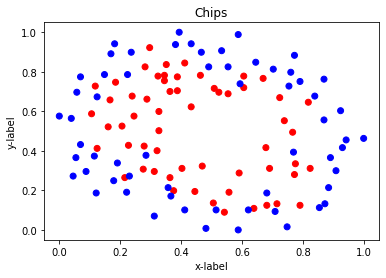

In [20]:
visualization_initial_data(chips, 'Chips')

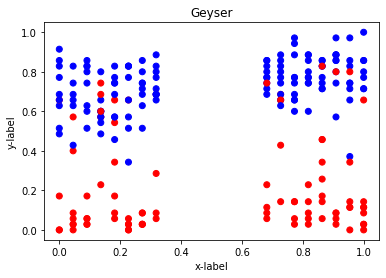

In [21]:
visualization_initial_data(geyser, 'Geyser')

In [22]:
x = geyser.values[:, :-1]
y = geyser.values[:, -1]

In [56]:
# hyperparameter_optimization(x, y)

----------
Kernel:  Linear kernel
Parameter:  None
Accuracy:  0.9055194805194805
C:  0.5
----------
Kernel:  Polynomial kernel
Parameter:  2
Accuracy:  0.8965097402597402
C:  1.0
----------
Kernel:  Polynomial kernel
Parameter:  3
Accuracy:  0.8965097402597402
C:  0.5
----------
Kernel:  Polynomial kernel
Parameter:  4
Accuracy:  0.8205357142857144
C:  5.0
----------
Kernel:  Polynomial kernel
Parameter:  5
Accuracy:  0.8116883116883116
C:  1.0
----------
Kernel:  Gaussian kernel
Parameter:  1
Accuracy:  0.8919642857142857
C:  1.0
----------
Kernel:  Gaussian kernel
Parameter:  2
Accuracy:  0.8964285714285714
C:  0.1
----------
Kernel:  Gaussian kernel
Parameter:  3
Accuracy:  0.9010551948051948
C:  100.0
----------
Kernel:  Gaussian kernel
Parameter:  4
Accuracy:  0.900974025974026
C:  0.05
----------
Kernel:  Gaussian kernel
Parameter:  5
Accuracy:  0.8964285714285714
C:  0.05


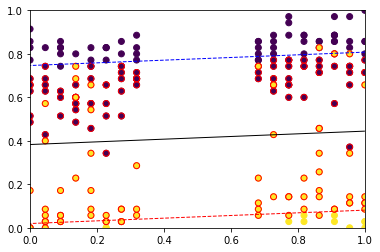

In [26]:
model = SMOModel(x, y, 0.1, LinearKernel(1))
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

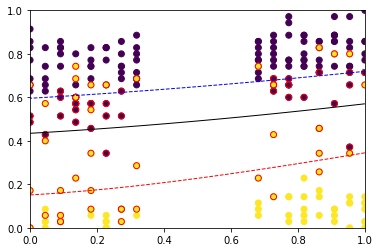

In [30]:
model = SMOModel(x, y, 100, PolynomialKernel(2))
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

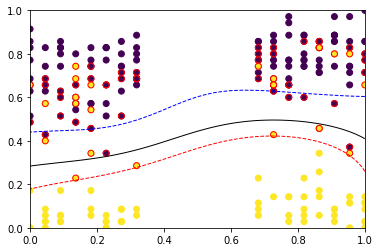

In [32]:
model = SMOModel(x, y, 50, GaussianKernel(5))
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

In [39]:
x = chips.values[:, :-1]
y = chips.values[:, -1]

In [21]:
hyperparameter_optimization(x, y)

----------
Kernel:  Linear kernel
Parameter:  None
Accuracy:  0.5166666666666666
C:  0.05
----------
Kernel:  Polynomial kernel
Parameter:  2
Accuracy:  0.6729885057471264
C:  10.0
----------
Kernel:  Polynomial kernel
Parameter:  3
Accuracy:  0.6
C:  5.0
----------
Kernel:  Polynomial kernel
Parameter:  4
Accuracy:  0.6028735632183908
C:  100.0
----------
Kernel:  Polynomial kernel
Parameter:  5
Accuracy:  0.6916666666666667
C:  0.5
----------
Kernel:  Gaussian kernel
Parameter:  1
Accuracy:  0.6643678160919539
C:  10.0
----------
Kernel:  Gaussian kernel
Parameter:  2
Accuracy:  0.803735632183908
C:  50.0
----------
Kernel:  Gaussian kernel
Parameter:  3
Accuracy:  0.7833333333333333
C:  5.0
----------
Kernel:  Gaussian kernel
Parameter:  4
Accuracy:  0.7574712643678161
C:  100.0
----------
Kernel:  Gaussian kernel
Parameter:  5
Accuracy:  0.9163793103448277
C:  50.0


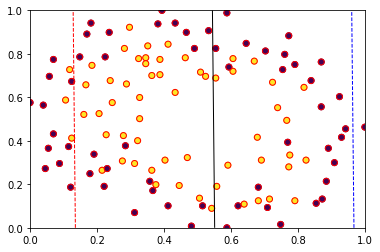

In [41]:
model = SMOModel(x, y, 5, LinearKernel(0))
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

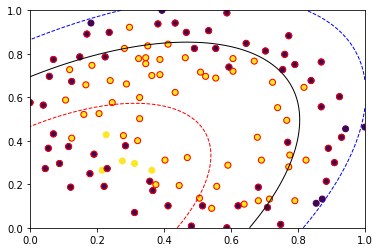

In [44]:
model = SMOModel(x, y, 50, PolynomialKernel(2))
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

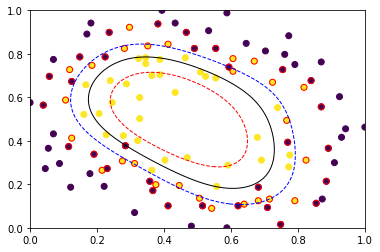

In [43]:
model = SMOModel(x, y, 50, GaussianKernel(4))
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)